In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import seaborn as sns
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import spc_os
from spc_vis import my_plot_ppc
RANDOM_SEED = 28101990
from pymc3 import DensityDist
from pymc3.math import switch,exp
import pickle

import theano.tensor as T
import scipy.stats as st

In [2]:
raw_data_dir = '../data/raw/'
interim_data_dir = '../data/interim/'
processed_data_dir = '../data/processed/'
external_data_dir = '../data/external/'
models_dir = '../models/'

In [3]:
model_path = models_dir + f"kinetic_modelling_mem_patch_sep.nc"

In [4]:
infer=True

# Load data

In [5]:
df = pd.read_csv(f'{processed_data_dir}data.csv').drop('Unnamed: 0', axis=1)

Drop data that has nans

In [6]:
df = df.dropna()

In [7]:
df.membrane=df.membrane.astype('category')

In [8]:
df['membrane_enc'] = df.membrane.cat.codes

In [9]:
category_dic = {
    i:cat for i,cat in enumerate(np.unique(df['membrane']))
}

In [10]:
category_dic

{0: 'APM1',
 1: 'APM2',
 2: 'APM3',
 3: 'APM4',
 4: 'BPM1',
 5: 'BPM2',
 6: 'BPM3',
 7: 'BPM4'}

PU, MU, PS; ZWITT,NCHG;

## Visualize Data

In [11]:
df['tpore'].groupby(df['membrane']).describe()

,count,mean,std,min,25%,50%,75%,max
membrane,,,,,,,,
APM1,60.0,2.575000,1.037047,1.1,1.875,2.40,3.125,5.4
APM2,60.0,3.090000,1.461448,1.0,1.900,2.75,4.000,8.2
APM3,60.0,3.766667,1.699917,1.3,2.650,3.40,4.500,9.4
APM4,60.0,3.725000,1.874506,1.1,2.375,3.25,5.400,8.6
BPM1,30.0,4.226667,1.958700,1.5,2.950,4.20,4.600,11.4
BPM2,30.0,5.016667,2.542749,2.2,3.625,4.40,5.075,13.1
BPM3,30.0,10.403333,4.982416,3.3,5.725,10.80,14.300,19.9
BPM4,30.0,6.396667,3.660081,2.4,4.150,5.30,8.400,21.1


In [12]:
min_val = df['tpore'].groupby(df['membrane']).min()

array([[<AxesSubplot:title={'center':'APM1'}>,
        <AxesSubplot:title={'center':'APM2'}>,
        <AxesSubplot:title={'center':'APM3'}>],
       [<AxesSubplot:title={'center':'APM4'}>,
        <AxesSubplot:title={'center':'BPM1'}>,
        <AxesSubplot:title={'center':'BPM2'}>],
       [<AxesSubplot:title={'center':'BPM3'}>,
        <AxesSubplot:title={'center':'BPM4'}>, <AxesSubplot:>]],
      dtype=object)

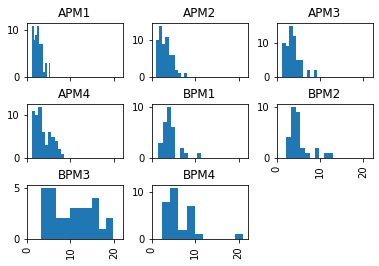

In [13]:
df['tpore'].hist(by=df['membrane'],sharex=True)

<AxesSubplot:>

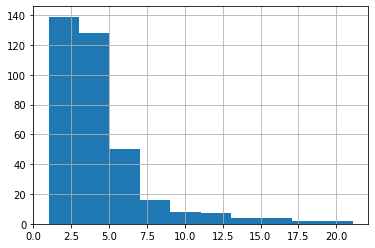

In [14]:
df['tpore'].hist()

# Non-Hierarchical Model

In [15]:
def logp_exp_lag(tau_0, tau):
    def logp_(t):
        #return T.log(T.switch(T.lt(t, tau_0), np.finfo(np.float64).tiny,T.exp( - (t - tau_0) / tau)/ tau ))
        return T.switch(T.lt(t, tau_0), - np.finfo(np.float64).max,  - (t - tau_0) / tau -  T.log( tau ))
    return  logp_

In [16]:
def exp_lag_cdf(t, tau_0, tau):
    if t < tau_0:
        cdf = 0.0
    elif t >= tau_0:
        cdf = 1-np.exp(-(t-tau_0)/tau)
    return cdf

In [17]:
exp_lag_cdf_vec = np.vectorize(exp_lag_cdf)

In [18]:
class my_pdf(st.rv_continuous):
    
    def _cdf(self,t,tau_0, tau):
        return exp_lag_cdf_vec(t, tau_0, tau)
my_cv = my_pdf(a=0, name='my_pdf')

In [19]:
from pymc3.distributions import draw_values, generate_samples
def random(point=None, size=None):
    # draw a numerical value for the parameters
    size = 1 if size is None else size
    tau_0_, tau_ = draw_values([tau_0, tau], point=point,size=size)
    
 
    return generate_samples(my_cv.rvs, tau=tau_, tau_0=tau_0_, size=size)

In [20]:
d = DensityDist.dist(logp_exp_lag).logp(0.5,1/3)

In [21]:
l = []
for i in range(1000):
    l.append(my_cv.rvs(tau_0=0.5,tau=1/3))

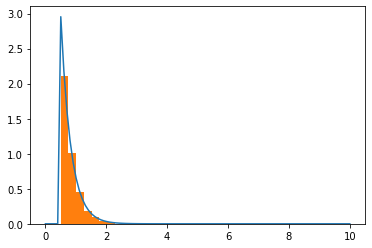

In [22]:
plt.plot(np.linspace(0,10,100),np.exp(d(np.linspace(0,10,100)).eval()))
_ = plt.hist(np.array(l), density=True)

## Visualize Priors

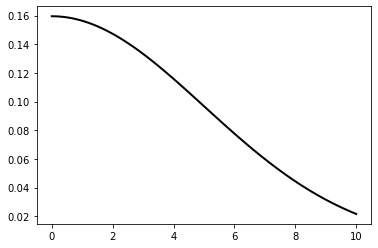

In [23]:
scale = 5
d = st.halfnorm(scale=scale)
x = np.linspace(0,10,100)
plt.plot(x, d.pdf(x), 'k-', lw=2)

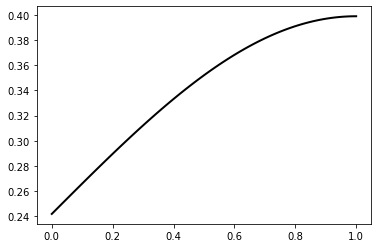

In [24]:
scale = 1
d = st.norm(scale=scale,loc=1)
x = np.linspace(0,1,100)
plt.plot(x, d.pdf(x), 'k-', lw=2)

## Run model

In [25]:
shape = df['membrane_enc'].unique().shape

In [26]:
shape = df['membrane_enc'].unique().shape
with pm.Model() as my_model:
    tau = pm.HalfNormal('tau', sigma=5.,shape =shape)
    tau_0 = pm.TruncatedNormal('tau_0', mu = min_val, sigma = 1, lower = 0, upper = min_val, shape =shape)
    like = DensityDist('like', logp_exp_lag(tau_0[df['membrane_enc']],tau[df['membrane_enc']]), observed=df['tpore'], random=random)

In [27]:
if infer:
    with my_model:
        my_model_trace = pm.sample(4000, tune=3000,  random_seed=RANDOM_SEED)
        ppc = pm.sample_posterior_predictive(my_model_trace,  random_seed=RANDOM_SEED, samples=40, size=1000)
        my_model_trace = az.from_pymc3(trace=my_model_trace, posterior_predictive=ppc)
        print('Done infering.')

        my_model_trace = my_model_trace.assign_coords(tau_0_dim_0=[category_dic[i] for i in my_model_trace.posterior.tau_0_dim_0.to_index()])
        my_model_trace = my_model_trace.assign_coords(tau_dim_0=[category_dic[i] for i in my_model_trace.posterior.tau_dim_0.to_index()])
        
        spc_os.remove(model_path)
        my_model_trace.to_netcdf(model_path)
else:
    my_model_trace=az.from_netcdf(model_path)

/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_0, tau]


Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 9 seconds.
/home/sperez/data_partition/bin2/anaconda3/envs/electroporation_modeling/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


arviz.data.io_pymc3 - WARNING - posterior predictive variable like's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


Done infering.


## Analyze

### Point Summaries

Check that r_hat is approx 1 and that ess_mean is near to the number of steps.

In [30]:
df_summary = az.summary(my_model_trace)
with pd.option_context('display.max_rows', None):
    print(df_summary)

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
tau[0]    1.551  0.208   1.169    1.931      0.001    0.001   24641.0   
tau[1]    2.192  0.291   1.678    2.750      0.002    0.001   27910.0   
tau[2]    2.584  0.345   1.958    3.226      0.002    0.002   25634.0   
tau[3]    2.746  0.361   2.090    3.426      0.002    0.002   26765.0   
tau[4]    2.983  0.568   2.035    4.079      0.004    0.003   22572.0   
tau[5]    3.080  0.585   2.085    4.184      0.004    0.003   24216.0   
tau[6]    7.244  1.248   5.081    9.643      0.008    0.006   27423.0   
tau[7]    4.306  0.809   2.947    5.859      0.005    0.004   23946.0   
tau_0[0]  1.074  0.026   1.027    1.100      0.000    0.000   20118.0   
tau_0[1]  0.963  0.037   0.895    1.000      0.000    0.000   22645.0   
tau_0[2]  1.257  0.043   1.179    1.300      0.000    0.000   21959.0   
tau_0[3]  1.054  0.048   0.970    1.100      0.000    0.000   21014.0   
tau_0[4]  1.403  0.097   1.230    1.500      0.001 

### Plot Traces (Posteriors)

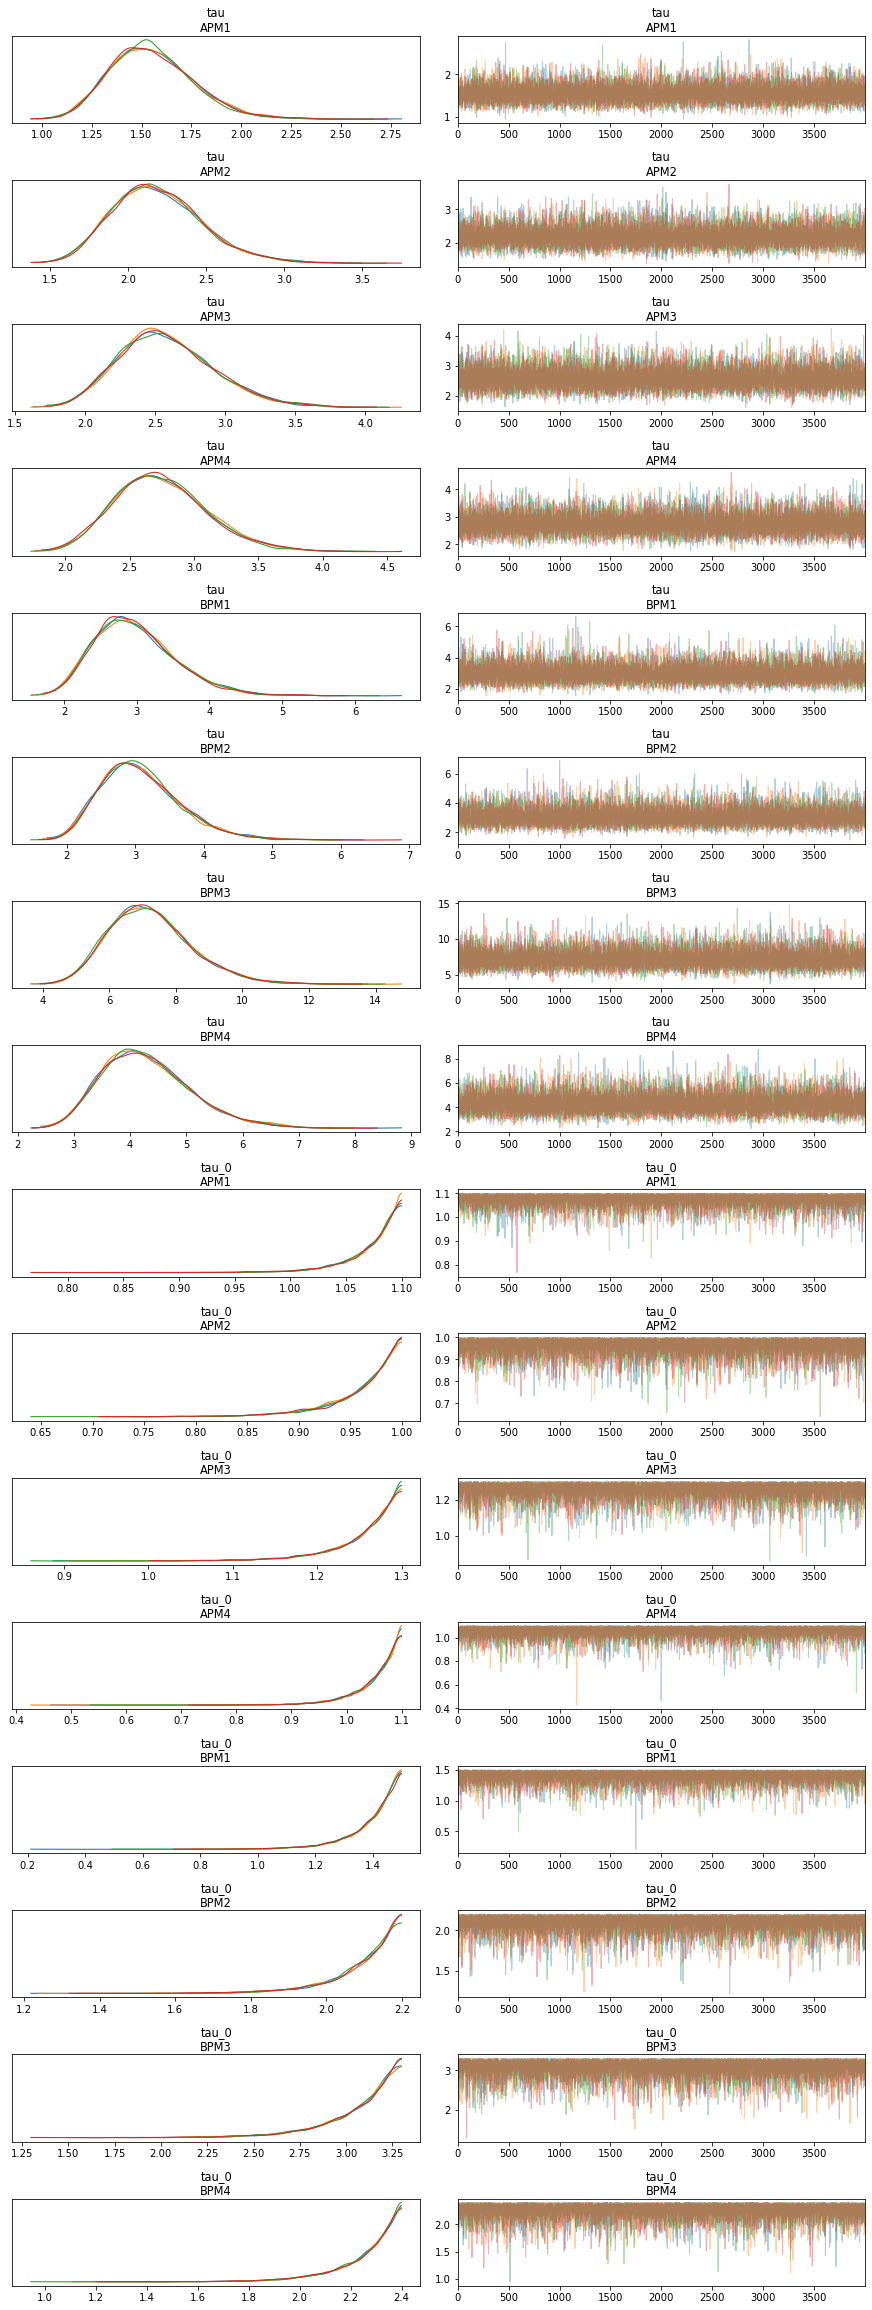

In [31]:
with az.rc_context(rc={'plot.max_subplots': None}):
        az.plot_trace(my_model_trace)

### Autocorrelations

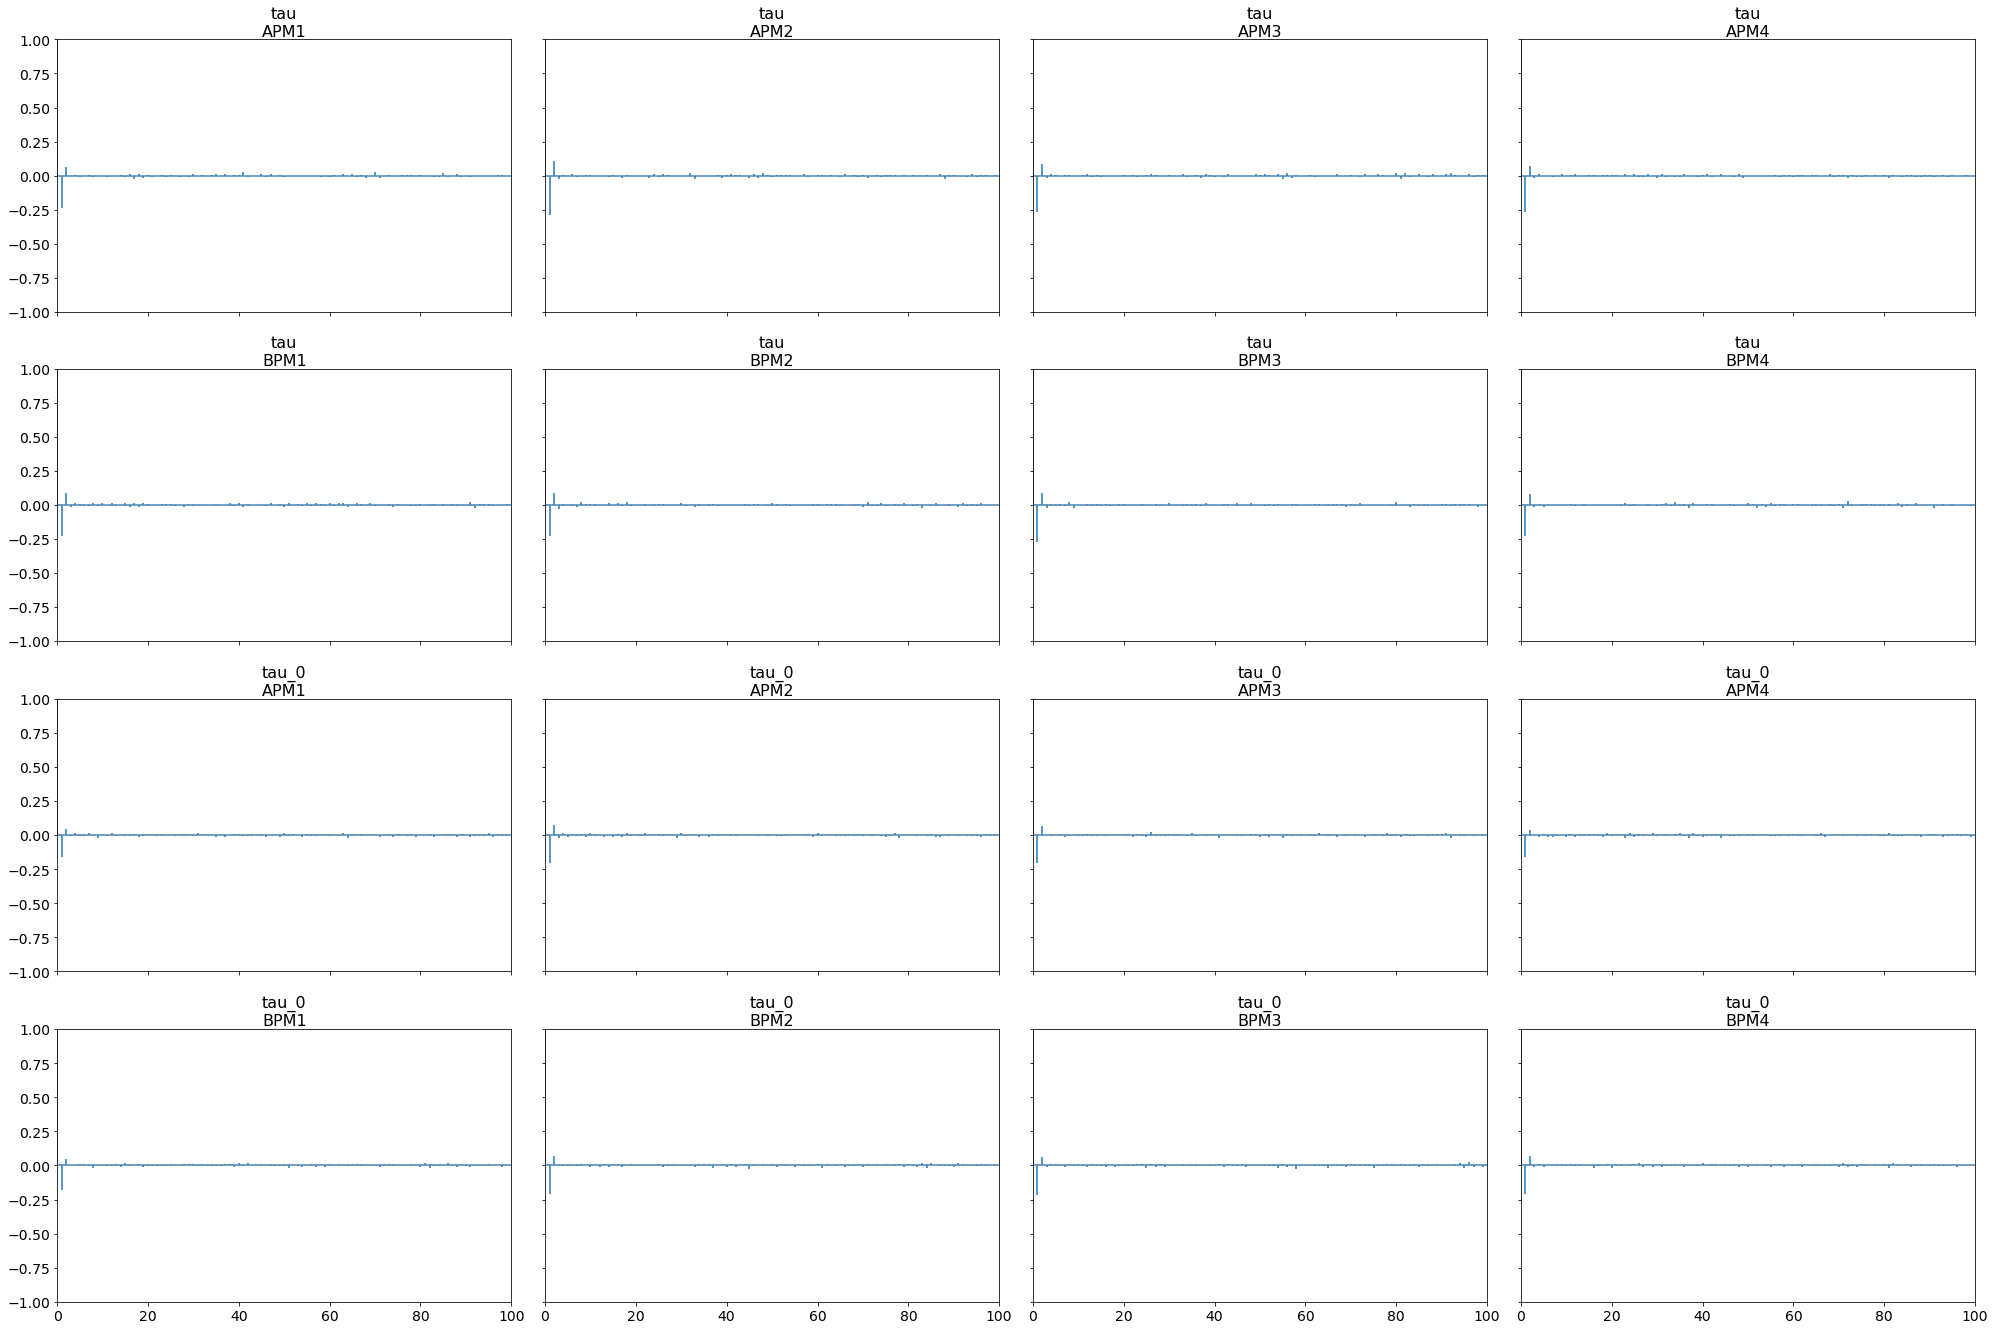

In [32]:
with az.rc_context(rc={'plot.max_subplots': None}):
    az.plot_autocorr(my_model_trace, combined=True)

### Posterior Predictive Test

2 2.0 2
dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


(<Figure size 1440x792 with 8 Axes>,
 array([<AxesSubplot:xlabel='ppc var APM1'>,
        <AxesSubplot:xlabel='ppc var APM2'>,
        <AxesSubplot:xlabel='ppc var APM3'>,
        <AxesSubplot:xlabel='ppc var APM4'>,
        <AxesSubplot:xlabel='ppc var BPM1'>,
        <AxesSubplot:xlabel='ppc var BPM2'>,
        <AxesSubplot:xlabel='ppc var BPM3'>,
        <AxesSubplot:xlabel='ppc var BPM4'>], dtype=object))

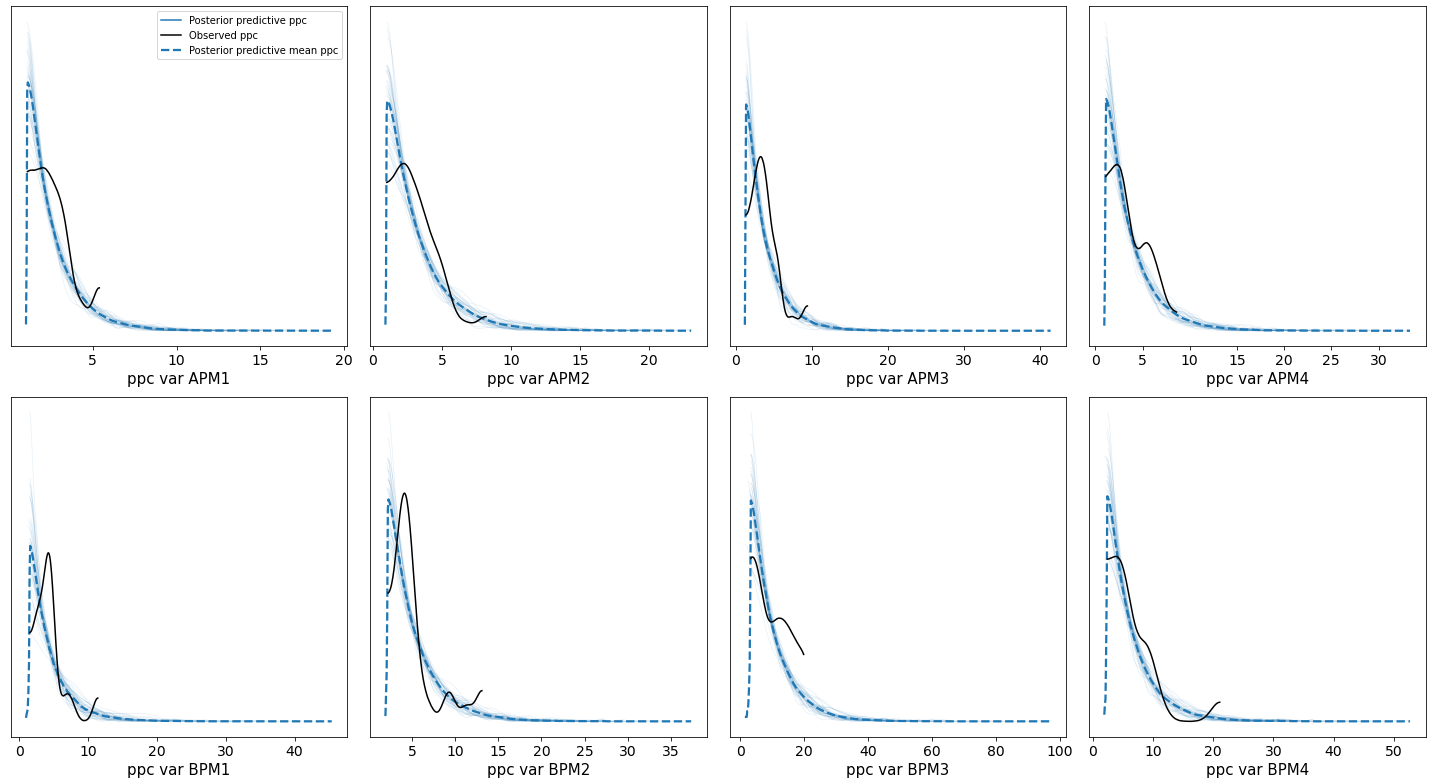

In [33]:
my_plot_ppc(my_model_trace, df.membrane_enc,category_dic, alpha=0.1)

### Compare parameter

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

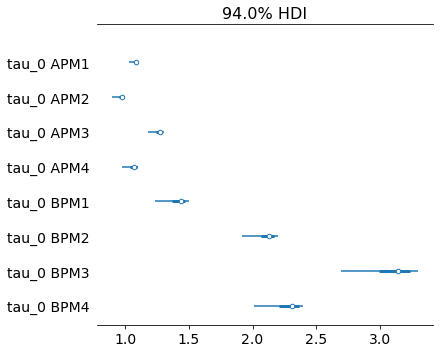

In [34]:
variable = 'tau_0'
az.plot_forest(my_model_trace,
               var_names=variable,
               combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

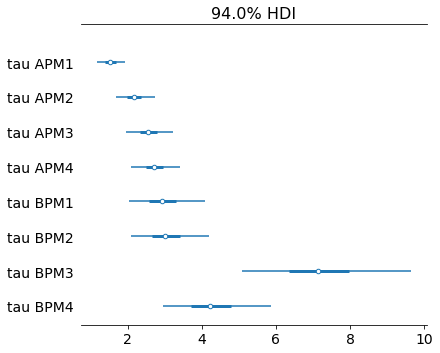

In [36]:
variable = 'tau'
az.plot_forest(my_model_trace,
               var_names=variable,
               combined=True)